<a href="https://colab.research.google.com/github/bulinayas/Deep-deep-learning/blob/main/%5Bseminar%5Dneuron_pytorch_CrossEntropyLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Копия apples_pears.csv")

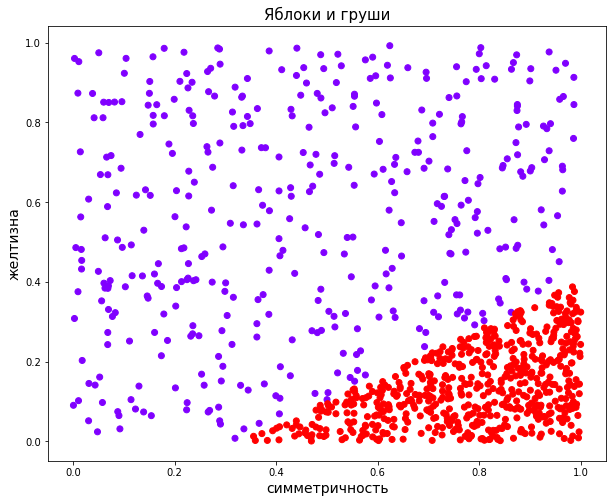

In [5]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [6]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [7]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [8]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [9]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [10]:
neuron(torch.FloatTensor([1, 1]).requires_grad_(requires_grad = True))

tensor([0.2731], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

In [11]:
proba_pred = neuron(torch.FloatTensor(X).requires_grad_(requires_grad = True))
y_pred = proba_pred > 0.5
type(y_pred)

torch.Tensor

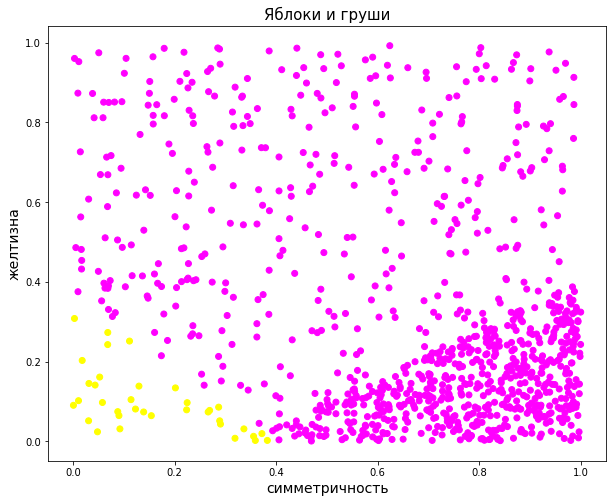

In [12]:
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [13]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.FloatTensor(y)

Код обучения одного нейрона на PyTorch:

In [14]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(reduction = 'sum')

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
num_epochs = 500
for t in range(num_epochs):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 266.03546142578125
1 250.0356903076172
2 237.83013916015625
3 228.60333251953125
4 221.51011657714844
5 215.86727905273438
6 211.18756103515625
7 207.1455078125
8 203.53152465820312
9 200.2126922607422
10 197.10548400878906
11 194.15744018554688
12 191.33546447753906
13 188.61859130859375
14 185.9932861328125
15 183.4505615234375
16 180.98435974121094
17 178.5902557373047
18 176.2649383544922
19 174.00567626953125
20 171.81019592285156
21 169.67636108398438
22 167.6022491455078
23 165.5859832763672
24 163.62576293945312
25 161.7198486328125
26 159.8665008544922
27 158.06405639648438
28 156.3108673095703
29 154.6053466796875
30 152.94589233398438
31 151.33099365234375
32 149.75917053222656
33 148.22894287109375
34 146.7389678955078
35 145.28781127929688
36 143.87420654296875
37 142.49688720703125
38 141.15460205078125
39 139.8461456298828
40 138.57041931152344
41 137.32626342773438
42 136.11264038085938
43 134.92852783203125
44 133.77291870117188
45 132.64488220214844
46 131.543487548

Обучили. Предскажем теперь:

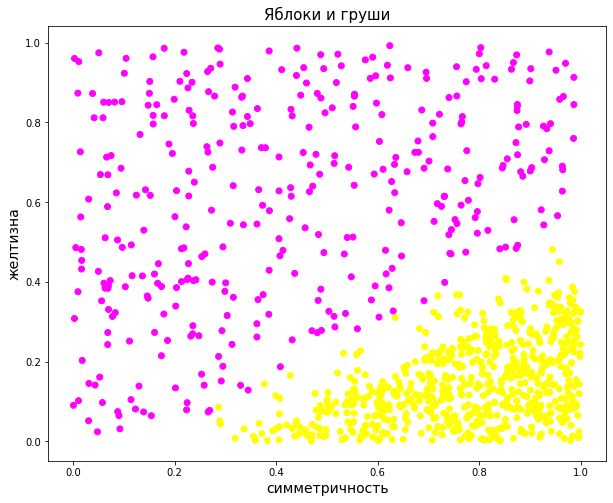

In [15]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [16]:
one_hot = pd.get_dummies(data['target'])
data = data.join(one_hot)
data

,yellowness,symmetry,target,0.0,1.0
0,0.779427,0.257305,1.0,0,1
1,0.777005,0.015915,1.0,0,1
2,0.977092,0.304210,1.0,0,1
3,0.043032,0.140899,0.0,1,0
4,0.760433,0.193123,1.0,0,1
...,...,...,...,...,...
995,0.288482,0.051186,0.0,1,0
996,0.892424,0.795257,0.0,1,0
997,0.927219,0.134986,1.0,0,1
998,0.015830,0.481322,0.0,1,0


In [66]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data.iloc[:,3].values  # классы 

In [67]:
num_features = X.shape[1]
neuron = torch.nn.Sequential(
    torch.nn.Linear(in_features=num_features, out_features = 2),
    torch.nn.Softmax()
)

In [68]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.LongTensor(y)

In [69]:
y_pred = neuron(X)
y_pred.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([1000, 2])

In [71]:
loss_fn = torch.nn.NLLLoss(reduction='sum')
loss = loss_fn(y_pred, y.view(-1))
loss

tensor(-526.4135, grad_fn=<NllLossBackward0>)

In [21]:
loss_fn = torch.nn.NLLLoss(reduction='sum')
optimizer = torch.optim.Adam(neuron.parameters(), lr = 0.01)

num_epochs = 10000
for i in range(num_epochs):
  y_pred = neuron(X)
  loss = loss_fn(y_pred, y.view(-1))
  print('{} {}'.format(i, loss.data))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.
5000 -965.2201538085938
5001 -965.2261352539062
5002 -965.23193359375
5003 -965.23779296875
5004 -965.2437133789062
5005 -965.2495727539062
5006 -965.2554931640625
5007 -965.2613525390625
5008 -965.2672729492188
5009 -965.2731323242188
5010 -965.2789916992188
5011 -965.2849731445312
5012 -965.2908935546875
5013 -965.2967529296875
5014 -965.302734375
5015 -965.3084716796875
5016 -965.3143310546875
5017 -965.3202514648438
5018 -965.3261108398438
5019 -965.33203125
5020 -965.337890625
5021 -965.34375
5022 -965.349609375
5023 -965.3555297851562
5024 -965.3613891601562
5025 -965.3671875
5026 -965.373046875
5027 -965.3789672851562
5028 -965.3848876953125
5029 -965.3906860351562
5030 -965.3965454101562
5031 -965.4024047851562
5032 -965.4082641601562
5033 -965.4141845703125
5034 -965.4199829101562
5035 -965.4259033203125
5036 -965.4317626953125
5037 -965.4375610351562
5038 -965.4434814453125
5039 -965.44921875
5040 -965.4551391601562
5041 -965

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


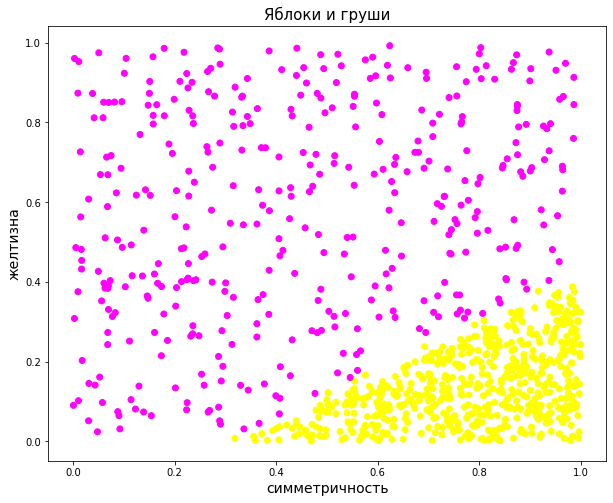

In [22]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred[:,0].data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [96]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы 

In [97]:
num_feachers = X.shape[1]
neuron = torch.nn.Sequential(
    torch.nn.Linear(in_features=num_features, out_features=1),
    torch.nn.Sigmoid()
)

In [98]:
X = torch.FloatTensor(X).requires_grad_(requires_grad = True)
y = torch.FloatTensor(y)
y.shape

torch.Size([1000, 1])

In [101]:
y_pred = neuron(X)
print(y_pred.shape)
loss_fn = torch.nn.CrossEntropyLoss(reduction = 'sum')
loss = loss_fn(y_pred, y)
loss

torch.Size([1000, 1])


tensor(-0., grad_fn=<NegBackward0>)

In [80]:
num_epochs = 100
loss_fn = torch.nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.Adam(neuron.parameters(), lr=0.001)

for i in range(num_epochs):
  y_pred = neuron(X)
  loss = loss_fn(y_pred, y)
  print('{} {}'.format(i, loss.data))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 -0.0
1 -0.0
2 -0.0
3 -0.0
4 -0.0
5 -0.0
6 -0.0
7 -0.0
8 -0.0
9 -0.0
10 -0.0
11 -0.0
12 -0.0
13 -0.0
14 -0.0
15 -0.0
16 -0.0
17 -0.0
18 -0.0
19 -0.0
20 -0.0
21 -0.0
22 -0.0
23 -0.0
24 -0.0
25 -0.0
26 -0.0
27 -0.0
28 -0.0
29 -0.0
30 -0.0
31 -0.0
32 -0.0
33 -0.0
34 -0.0
35 -0.0
36 -0.0
37 -0.0
38 -0.0
39 -0.0
40 -0.0
41 -0.0
42 -0.0
43 -0.0
44 -0.0
45 -0.0
46 -0.0
47 -0.0
48 -0.0
49 -0.0
50 -0.0
51 -0.0
52 -0.0
53 -0.0
54 -0.0
55 -0.0
56 -0.0
57 -0.0
58 -0.0
59 -0.0
60 -0.0
61 -0.0
62 -0.0
63 -0.0
64 -0.0
65 -0.0
66 -0.0
67 -0.0
68 -0.0
69 -0.0
70 -0.0
71 -0.0
72 -0.0
73 -0.0
74 -0.0
75 -0.0
76 -0.0
77 -0.0
78 -0.0
79 -0.0
80 -0.0
81 -0.0
82 -0.0
83 -0.0
84 -0.0
85 -0.0
86 -0.0
87 -0.0
88 -0.0
89 -0.0
90 -0.0
91 -0.0
92 -0.0
93 -0.0
94 -0.0
95 -0.0
96 -0.0
97 -0.0
98 -0.0
99 -0.0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


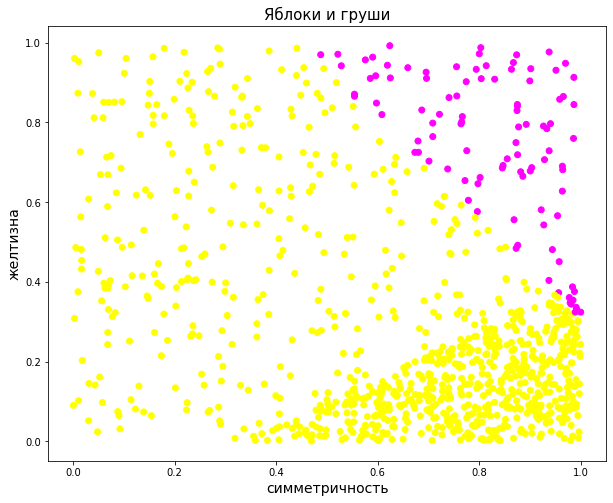

In [28]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

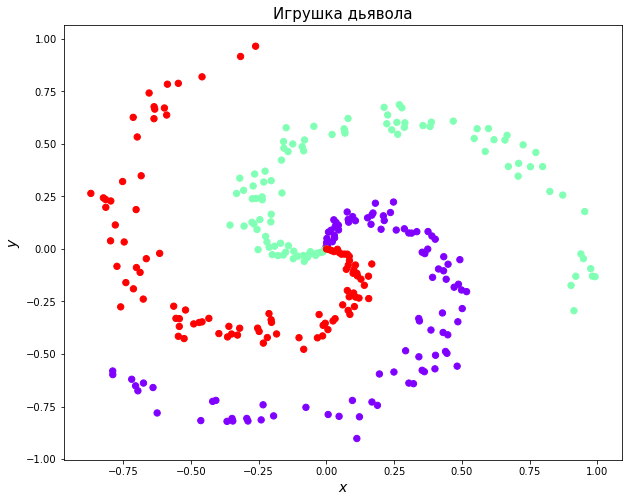

In [ ]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [ ]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [ ]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [ ]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 
 357.2256
[torch.FloatTensor of size 1]

1 
 356.7443
[torch.FloatTensor of size 1]

2 
 356.2664
[torch.FloatTensor of size 1]

3 
 355.7916
[torch.FloatTensor of size 1]

4 
 355.3206
[torch.FloatTensor of size 1]

5 
 354.8528
[torch.FloatTensor of size 1]

6 
 354.3882
[torch.FloatTensor of size 1]

7 
 353.9270
[torch.FloatTensor of size 1]

8 
 353.4688
[torch.FloatTensor of size 1]

9 
 353.0139
[torch.FloatTensor of size 1]

10 
 352.5622
[torch.FloatTensor of size 1]

11 
 352.1138
[torch.FloatTensor of size 1]

12 
 351.6683
[torch.FloatTensor of size 1]

13 
 351.2257
[torch.FloatTensor of size 1]

14 
 350.7863
[torch.FloatTensor of size 1]

15 
 350.3502
[torch.FloatTensor of size 1]

16 
 349.9168
[torch.FloatTensor of size 1]

17 
 349.4862
[torch.FloatTensor of size 1]

18 
 349.0590
[torch.FloatTensor of size 1]

19 
 348.6344
[torch.FloatTensor of size 1]

20 
 348.2126
[torch.FloatTensor of size 1]

21 
 347.7941
[torch.FloatTensor of size 1]

22 
 347.3780
[torch


181 
 303.7340
[torch.FloatTensor of size 1]

182 
 303.5471
[torch.FloatTensor of size 1]

183 
 303.3607
[torch.FloatTensor of size 1]

184 
 303.1752
[torch.FloatTensor of size 1]

185 
 302.9904
[torch.FloatTensor of size 1]

186 
 302.8058
[torch.FloatTensor of size 1]

187 
 302.6225
[torch.FloatTensor of size 1]

188 
 302.4394
[torch.FloatTensor of size 1]

189 
 302.2571
[torch.FloatTensor of size 1]

190 
 302.0756
[torch.FloatTensor of size 1]

191 
 301.8947
[torch.FloatTensor of size 1]

192 
 301.7142
[torch.FloatTensor of size 1]

193 
 301.5347
[torch.FloatTensor of size 1]

194 
 301.3556
[torch.FloatTensor of size 1]

195 
 301.1772
[torch.FloatTensor of size 1]

196 
 300.9995
[torch.FloatTensor of size 1]

197 
 300.8224
[torch.FloatTensor of size 1]

198 
 300.6458
[torch.FloatTensor of size 1]

199 
 300.4700
[torch.FloatTensor of size 1]

200 
 300.2949
[torch.FloatTensor of size 1]

201 
 300.1203
[torch.FloatTensor of size 1]

202 
 299.9463
[torch.FloatTensor


360 
 278.4590
[torch.FloatTensor of size 1]

361 
 278.3530
[torch.FloatTensor of size 1]

362 
 278.2476
[torch.FloatTensor of size 1]

363 
 278.1425
[torch.FloatTensor of size 1]

364 
 278.0373
[torch.FloatTensor of size 1]

365 
 277.9326
[torch.FloatTensor of size 1]

366 
 277.8283
[torch.FloatTensor of size 1]

367 
 277.7242
[torch.FloatTensor of size 1]

368 
 277.6204
[torch.FloatTensor of size 1]

369 
 277.5170
[torch.FloatTensor of size 1]

370 
 277.4138
[torch.FloatTensor of size 1]

371 
 277.3110
[torch.FloatTensor of size 1]

372 
 277.2082
[torch.FloatTensor of size 1]

373 
 277.1059
[torch.FloatTensor of size 1]

374 
 277.0040
[torch.FloatTensor of size 1]

375 
 276.9023
[torch.FloatTensor of size 1]

376 
 276.8008
[torch.FloatTensor of size 1]

377 
 276.6997
[torch.FloatTensor of size 1]

378 
 276.5988
[torch.FloatTensor of size 1]

379 
 276.4982
[torch.FloatTensor of size 1]

380 
 276.3979
[torch.FloatTensor of size 1]

381 
 276.2979
[torch.FloatTensor

In [ ]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

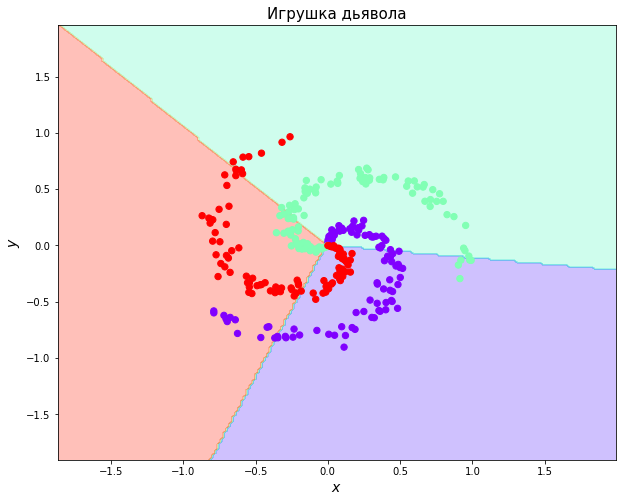

In [ ]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [ ]:
# Ваш код здесь (можно (и нужно) создавать несколько ячеек)

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*